 Создайте веб-сервис с помощью FastAPI, загрузите на него обученную модель MNIST и протестируйте ее на собственноручно написанных цифрах.




In [ ]:
# Загружаем библиотеки
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils 
from tensorflow.keras.preprocessing import image 
from google.colab import files 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
import random 
from google.colab import drive
%matplotlib inline

In [ ]:
# Загружаем MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# подготовка набора экземпляров класса

x_train = x_train_mnist.reshape(x_train_mnist.shape[0], -1)   
x_test = x_test_mnist.reshape(x_test_mnist.shape[0], -1)   

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

In [ ]:
# подготовка набора меток класса

from tensorflow.keras import utils              
y_train = utils.to_categorical(y_train_mnist, 10)
y_test = utils.to_categorical(y_test_mnist, 10)

In [ ]:
# проверка размерностей

print(x_train.shape)
print(y_train.shape)  

(60000, 784)
(60000, 10)


Epoch 1/10
469/469 [==============================] - 5s 6ms/step - loss: 0.2504 - accuracy: 0.9269 - val_loss: 0.1250 - val_accuracy: 0.9613
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0979 - accuracy: 0.9698 - val_loss: 0.0834 - val_accuracy: 0.9733
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0642 - accuracy: 0.9797 - val_loss: 0.0936 - val_accuracy: 0.9711
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0479 - accuracy: 0.9845 - val_loss: 0.0780 - val_accuracy: 0.9773
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0392 - accuracy: 0.9871 - val_loss: 0.0827 - val_accuracy: 0.9768
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0309 - accuracy: 0.9896 - val_loss: 0.0719 - val_accuracy: 0.9792
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0279 - accuracy: 0.9905 - val_loss: 0.0851 - val_accuracy: 0.9781
Epoch 

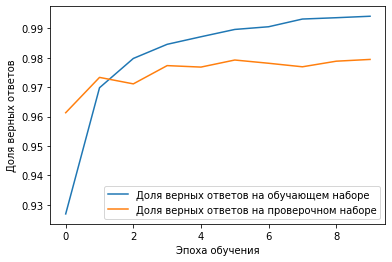

In [ ]:
# Создаем последовательную модель
model = Sequential()
# Полносвязный слой
model.add(Dense(200, input_dim=784, activation='relu'))
# Второй полносвязный слой
model.add(Dense(300, activation='relu'))
# Третий полносвязный слой
model.add(Dense(400, activation='relu'))
# Выходной полносвязный слой
model.add(Dense(10, activation='softmax'))

# Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Обучаем сеть
history = model.fit(x_train, y_train, batch_size=128, epochs=10,
                    validation_data=(x_test, y_test))

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Пересохранение обученной модели полностью (веса и архитектура)
model.save('model_mnist.h5')

In [ ]:
# Создадим программный файл с кодом для:
# инициализации модели;
# загрузки весов;
# работы модели в режиме распознавания;
# пред- и постобработки изображений.

predict_file = '''

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from io import BytesIO 
model = load_model('model_mnist.h5')

INPUT_SHAPE = (28, 28)


def process(image_file):
    img = Image.open(BytesIO(image_file))
    resized_image = img.resize((INPUT_SHAPE[1], INPUT_SHAPE[0]))
    img = image.img_to_array(resized_image)
    img = np.array(img[:,:,1])
    img = img.reshape(1,784)
    img = np.where(img > 170, 255, img)
    img = 255 - img
    prediction = model.predict(img)[0]
    return str({i:r for i, r in enumerate(prediction)})
'''

with open('predict.py', 'w') as file:
    file.write(predict_file)

In [ ]:
# Установим библиотеку FastAPI и вспомогательные компоненты
!pip install fastapi
!pip install uvicorn
!pip install python-multipart

     |████████████████████████████████| 51 kB 712 kB/s 
     |████████████████████████████████| 61 kB 318 kB/s 
     |████████████████████████████████| 10.1 MB 12.4 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=83ec3bbcfcc9ad8a9b89b9f10b4cdd7e135961de9c0e071c2fd1c8aec24ca10a
  Stored in directory: /root/.cache/pip/wheels/2c/41/7c/bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
Successfully built python-multipart


In [ ]:
#Создадим файл с тестовым API:

main_file = '''from fastapi import FastAPI

app = FastAPI()

@app.get("/test")
def read_root():
    return {"Hello": "World"}
'''

with open('main.py', 'w') as file:
    file.write(main_file)

In [ ]:
# Запустим http-сервер uvicorn с указанием приложения, которое будет запускаться (app из файла main.py)

!nohup uvicorn main:app --reload &
# nohup и & - прописываются для запуска процесса в фоне (чтобы не блокировать Colab)
# параметр --reload позволяет автоматически перезапускать uvicorn при изменениях в файле main.py

nohup: appending output to 'nohup.out'


In [ ]:
# Сделаем пробный запрос к созданнму эндпойнту (одному из адресов для запросов через API)
import requests
r = requests.get('http://127.0.0.1:8000/test')
print(r.status_code)
print(r.text)

200
{"Hello":"World"}


In [ ]:
# Создадим новый эндпойнт, который будет принимать файл с изображением и возвращать результат
main_file = '''from fastapi import FastAPI, File
from predict import process

app = FastAPI()


@app.post("/predict")
async def create_file(file: bytes = File(...)):
    return {"result": process(file)}
'''

with open('main.py', 'w') as file:
    file.write(main_file)

In [ ]:
# Отправим тестовое изображение на эндпойнт для классификации
files = {'file': open('digit.jpg','rb')}
r = requests.post('http://127.0.0.1:8000/predict', files=files)
print(r.text)

{"result":"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0, 9: 0.0}"}


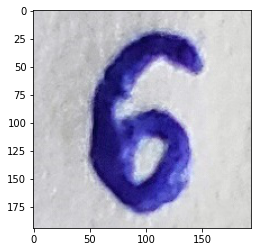

In [ ]:
# проверим ответ
plt.imshow(Image.open('digit.jpg'))
plt.show()

In [ ]:
# Создадим файл для запуска веб-службы
proc_file = 'web: uvicorn main:app --host=0.0.0.0 --port=${PORT:-5000}'

with open('Procfile', 'w') as file:
    file.write(proc_file)

In [ ]:
# Создадим файл зависимостей. В нем перечисляются требуемые пакеты Python и их версии
requirements_file = '''

fastapi==0.68.1
tensorflow-cpu==2.5.0
uvicorn==0.15.0
Pillow==7.1.2
python-multipart==0.0.5

'''

with open('requirements.txt', 'w') as file:
    file.write(requirements_file)

In [ ]:
# удалим лишние файлы из папки Google Colab
!rm -rf sample_data

In [ ]:
# Зададим имя пользователя и e-mail для Git
!git config --global user.email "amcloun@rambler.ru"
!git config --global user.name "Aleksandr Momotov"

In [ ]:
# Установим Heroku CLI (интерфейс командной строки)
!curl https://cli-assets.heroku.com/install-ubuntu.sh | sh > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1232  100  1232    0     0   7080      0 --:--:-- --:--:-- --:--:--  7040
+ dpkg -s apt-transport-https
+ echo 
+ apt-get update
+ apt-get install -y apt-transport-https
+ echo deb https://cli-assets.heroku.com/apt ./
+ dpkg -s heroku-toolbelt
+ true
+ apt-key add -
+ curl https://cli-assets.heroku.com/apt/release.key
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5393  100  5393    0     0  51361      0 --:--:-- --:--:-- --:--:-- 51361
+ apt-get update
+ apt-get install -y heroku
 ›   Warning: Our terms of service have changed: 
 ›   https://dashboard.heroku.com/terms-of-service


In [ ]:
# создаем файл .netrc
LOGIN = 'amcloun@rambler.ru'
API_KEY = 'b551c395-873c-4fe8-8718-854c24d78d86'

auth_file = '''machine api.heroku.com
  login {login}
  password {password}
machine git.heroku.com
  login {login}
  password {password}
'''.format(login=LOGIN, password=API_KEY)

with open('/root/.netrc', 'w') as file:
    file.write(auth_file)

In [ ]:
# Перед развертыванием приложения в Heroku необходимо инициализировать локальный репозиторий Git и зафиксировать в нем код приложения
!git init
!git add .
!git commit -m "My first commit"

Initialized empty Git repository in /content/.git/
[master (root-commit) f49ad67] My first commit
 22 files changed, 697 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/gce
 create mode 100644 .config/logs/2021.12.03/14.32.30.027140.log
 create mode 100644 .config/logs/2021.12.03/14.32.50.522723.log
 create mode 100644 .config/logs/2021.12.03/14.33.09.955489.log
 create mode 100644 .config/logs/2021.12.03/14.33.16.964195.log
 create mode 100644 .config/logs/2021.12.03/14.33.36.903459.log
 create mode 100644 .config/logs/2021.12.03/14.33.37.701606.log
 create mode 100644 Procfile
 create mode 100644 __pycache__/main.cpython-37.pyc
 create mode 100644 __pycache__/predict.cpython-37.pyc
 create mod

In [ ]:
# создаем удаленный репозиторий Heroku
!heroku create

Creating app... ⣾ 
⣽⣻⢿⡿⣟⣯⣷⣾Creating app... done, ⬢ cryptic-cove-51473
https://cryptic-cove-51473.herokuapp.com/ | https://git.heroku.com/cryptic-cove-51473.git


In [ ]:
# Для развертывания приложения в Heroku нужно использовать команду git push,
# чтобы отправить код из главной или основной ветки локального репозитория на удаленный сервер heroku
!git push heroku master

Counting objects: 29, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (22/22), done.
Writing objects: 100% (29/29), 3.55 MiB | 3.16 MiB/s, done.
Total 29 (delta 3), reused 0 (delta 0)
remote: Compressing source files... done.
remote: Building source:
remote: 
remote: -----> Building on the Heroku-20 stack
remote: -----> Determining which buildpack to use for this app
remote: -----> Python app detected
remote: -----> No Python version was specified. Using the buildpack default: python-3.9.9
remote:        To use a different version, see: https://devcenter.heroku.com/articles/python-runtimes
remote: -----> Installing python-3.9.9
remote: -----> Installing pip 21.3.1, setuptools 57.5.0 and wheel 0.37.0
remote: -----> Installing SQLite3
remote: -----> Installing requirements with pip
remote:        Collecting fastapi==0.68.1
remote:          Downloading fastapi-0.68.1-py3-none-any.whl (52 kB)
remote:        Collecting tensorflow-cpu==2.5.0
remote:          Download

In [ ]:
# Отправим запрос с изображением на удаленный сервер.
# Укажем в запросе URL, полученный на предыдущем шаге
files = {'file': open('digit.jpg','rb')}
r = requests.post('https://cryptic-cove-51473.herokuapp.com/predict', files=files)
print(r.text)

{"result":"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0, 9: 0.0}"}


Все правильно работает!